In [1]:
from script_proj_alloc import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
from scipy.stats import skew, kurtosis
from pandas.tseries.offsets import BDay

In [2]:
cac40 = pd.read_excel('cac40.xlsx').set_index('Date')
poids = pd.read_excel('poids.xlsx').rename(columns={'Poids dans l\'indice': 'weigth', 'Valeurs':'stock'})
bloom = pd.read_excel('bloomberg.xlsx').set_index('Date')

stocks = cac40.drop(columns='CAC 40').fillna(0)
indice = cac40['CAC 40']
poids['stock'] = stocks.columns
poids = poids.set_index('stock').squeeze()
divisor = indice/(stocks.dot(poids))
indice_recons = indice*divisor.iloc[-1]/divisor

stocks_nan_col = stocks.columns[(stocks == 0).any()].tolist()
stocks = cac40.drop(columns='CAC 40').dropna(axis=1)
poids = poids.drop(stocks_nan_col, axis=0)

start_date = cac40.index[252*5]
day_shift = 10

In [73]:
cols_with_nan = cac40.columns[cac40.isna().any()].tolist()
first_valid_index = {
    col: cac40[col].first_valid_index() for col in cols_with_nan
}
first_valid_index

{'Credit Agricole SA': Timestamp('2001-12-13 00:00:00'),
 'Electricite de France': Timestamp('2005-11-18 00:00:00'),
 'Gaz de France SA': Timestamp('2005-07-07 00:00:00'),
 'Suez SA': Timestamp('2008-07-22 00:00:00')}

## 1 - Test d'integration à l'ordre 1

In [3]:
def stat_features_log(price):
    price_log = np.log(price).dropna()
    log_return = price_log.diff().dropna()
    
    res_level  = adfuller(price_log)
    res_diff = adfuller(log_return)
    
    stat_ppt = {
        'adf stat level':res_level[0], 
        'adf stat diff': res_diff[0],
        'Mean': log_return.mean(),
        'Median': log_return.median(),
        'Max': log_return.max(),
        'Min': log_return.min(),
        'Std Dev': log_return.std(),
        'Skewness': skew(log_return, bias=False),
        'Excess Kurtosis': kurtosis(log_return, bias=False)  # excess kurtosis = kurtosis - 3
    }
    return stat_ppt

def stat_features_cac40(df):
    columns = df.columns
    stat_ppts = []
    for col in columns:
        stat_ppts.append(stat_features_log(df[col]))
    stat_features = pd.concat([pd.DataFrame({'Name':columns}), pd.DataFrame(stat_ppts)], axis=1).set_index('Name').T
    return stat_features
    
    

In [4]:
stat_features = stat_features_cac40(cac40)

In [69]:
df_stat_features = stat_features[['CAC 40'] + list(stocks.columns)]
df_stat_features

Name,CAC 40,Accor SA,Air Liquide,Alcatel-Lucent,Alstom,Arcelor Mittal,AXA SA,BNP Paribas,Bouygues,Cap Gemini SA,...,Schneider Electric SA,Societe Generale,STMicroelectronics NV,Total SA,Unibail-Rodamco,Vallourec,Veolia Environnement,Vinci SA,Vivendi,Tecnip
adf stat level,-1.883178,-2.171240,-1.037611,-2.281316,-2.028314,-1.103079,-2.211078,-2.202259,-1.703963,-3.099361,...,-1.677064,-1.322203,-1.668103,-1.386726,-1.067384,-0.686362,-1.278731,-0.953359,-2.707435,-1.299536
adf stat diff,-9.375244,-35.887541,-18.096865,-8.922190,-33.082992,-24.158740,-12.372429,-8.298160,-10.551639,-23.947989,...,-9.285584,-22.607008,-12.009862,-11.580606,-30.374909,-33.691175,-11.091774,-22.960687,-11.014526,-18.790353
Mean,-0.000165,-0.000016,0.000228,-0.001310,-0.000663,0.001013,-0.000365,0.000085,-0.000043,-0.000647,...,0.000048,-0.000141,-0.000769,0.000035,0.000520,0.001075,-0.000273,0.000387,-0.000525,0.000184
Median,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.000691,0.000000,0.000366,0.000000,0.000000,0.000000,0.000000,0.000443
Max,0.105946,0.116976,0.104291,0.340326,0.232732,0.224669,0.192925,0.188745,0.156657,0.234193,...,0.151643,0.181844,0.157556,0.127860,0.112536,0.229504,0.167089,0.166602,0.202721,0.156972
Min,-0.094715,-0.138587,-0.089920,-0.194859,-0.693143,-0.209882,-0.203500,-0.189262,-0.128792,-0.260919,...,-0.228132,-0.169076,-0.135297,-0.096405,-0.079850,-0.175229,-0.239611,-0.132831,-0.294680,-0.213213
Std Dev,0.015648,0.021694,0.016964,0.035628,0.040659,0.037056,0.029547,0.024353,0.023333,0.029772,...,0.022489,0.026152,0.026559,0.017597,0.017202,0.026103,0.021502,0.019411,0.026580,0.026669
Skewness,0.043773,-0.046822,-0.038143,0.142444,-2.045194,0.100547,0.269097,0.177911,0.270045,-0.131253,...,-0.458835,-0.167406,0.272037,0.123151,0.056404,0.069159,-0.418940,0.442352,-1.472300,-0.473785
Excess Kurtosis,5.531827,3.916057,4.144048,7.459311,40.394762,4.896470,6.431617,9.455153,5.212232,6.424845,...,9.260567,5.952556,2.667131,6.010895,3.108172,5.445456,12.800294,8.931354,24.575076,6.451126


In [74]:
df_stat_features.to_excel('index_stock_stats.xlsx')

In [68]:
(df_stat_features.loc['adf stat level'] > -3.4356).sum(), (df_stat_features.loc['adf stat diff'] > -3.4356).sum()

(36, 0)

#### **Conclusion 1 :** Toutes le séries sont intégrées d'ordre 1. Il ya néanmoins un stock qui est stationnaire au niveau 1%

## II - Testing cointegration

In [4]:
def coint_test(cal_period, n_list, freq_rank, indice, stocks, poids, day_shift=day_shift, start_date=start_date, end_date=pd.to_datetime("2007-01-02")):
    dates = pd.date_range(start=start_date, end=end_date, freq=f"{day_shift}B")
    coint_test_res = np.zeros((len(n_list), len(dates)))
    critical_values = np.zeros(len(n_list))
    for i, n in enumerate(n_list):
        for j, T in enumerate(dates):
            tickers = select_stocks(T, n, freq_rank, stocks, poids, day_shift)
            stocks_cal, indice_select = select_calibration_data(T, cal_period, tickers, indice, stocks)
            _, coint_t, crit = perform_lr_coint_test(stocks_cal, indice_select)
            coint_test_res[i,j] = coint_t
        critical_values[i] = crit[0]
    return coint_test_res, dates, critical_values

In [79]:
n_list = np.array([10, 20, 25, 30, 36])
end_date = pd.to_datetime("2009-01-02")
freq_rank = 3
tracked_index = indice

coint_test_res_1, dates, critical_values_1 = coint_test(1, n_list, freq_rank, tracked_index, stocks, poids, day_shift, start_date, end_date)
coint_test_res_3, _, critical_values_3 = coint_test(3, n_list, freq_rank, tracked_index, stocks, poids, day_shift, start_date, end_date)
coint_test_res_4, _, critical_values_4 = coint_test(4, n_list, freq_rank, tracked_index, stocks, poids, day_shift, start_date, end_date)
coint_test_res_5, _, critical_values_5 = coint_test(5, n_list, freq_rank, tracked_index, stocks, poids, day_shift, start_date, end_date)

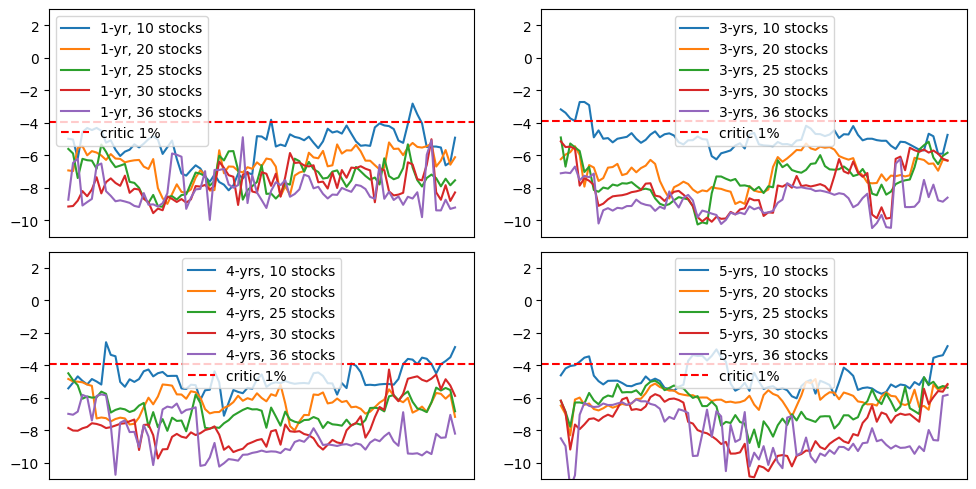

In [80]:
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
for i in range(len(coint_test_res_1)):
    axs[0,0].plot(dates, coint_test_res_1[i], label=f'1-yr, {n_list[i]} stocks')
    axs[0,1].plot(dates, coint_test_res_3[i], label=f'3-yrs, {n_list[i]} stocks')
    axs[1,0].plot(dates, coint_test_res_4[i], label=f'4-yrs, {n_list[i]} stocks')
    axs[1,1].plot(dates, coint_test_res_5[i], label=f'5-yrs, {n_list[i]} stocks')

axs[0,0].axhline(y=critical_values_1[0], color='r', linestyle='--', label="critic 1%")
axs[0,1].axhline(y=critical_values_3[0], color='r', linestyle='--', label="critic 1%")
axs[1,0].axhline(y=critical_values_4[0], color='r', linestyle='--', label="critic 1%")
axs[1,1].axhline(y=critical_values_5[0], color='r', linestyle='--', label="critic 1%")

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

axs[0,0].set_ylim(-11,3)
axs[0,1].set_ylim(-11,3)
axs[1,0].set_ylim(-11,3)
axs[1,1].set_ylim(-11,3)

axs[0,0].xaxis.set_visible(False)
axs[1,0].xaxis.set_visible(False)
axs[0,1].xaxis.set_visible(False)
axs[1,1].xaxis.set_visible(False)


fig.tight_layout()

## III - Index tracking

In [3]:
select_strat = 'RD'
freq_rank = 0
n_list = np.array([25, 30, 36])
cal_period_list = np.array([3, 4, 5])
day_shift = 10
end_date = stocks.index[-1]
tracked_index = indice
trackers_dict = {}
for n in n_list:
    for cal_period in cal_period_list:
        tracker_ret, tracker_TC_unit, coint_t = tracking_portf(n, freq_rank, select_strat, cal_period, start_date, end_date, 
                                                                  tracked_index, day_shift, stocks, poids)
        trackers_dict[(n, cal_period)] = [tracker_ret, tracker_TC_unit, coint_t]

In [75]:
ind_features = index_features(tracked_index, start_date).T

In [76]:
df_res_tracking = results_tracking(trackers_dict, tracked_index, start_date)
df_res_tracking

,n,cal_period,adf,ret_an(%),vol_an(%),ret_sharpe,ret_corr,ret_skew,ret_kurt,ret_tc_an(%),vol_tc_an(%),ret_tc_shar,ret_tc_corr,ret_tc_skew,ret_tc_kurt
0,25,3,-7.408916,-1.113976,25.935798,-0.042951,0.956597,0.245848,9.574950,-1.660463,25.935191,-0.064024,0.956580,0.246517,9.575105
1,25,4,-7.526528,-1.400185,25.853389,-0.054159,0.955974,0.236923,8.428237,-1.948245,25.852770,-0.075359,0.955960,0.237512,8.427373
2,25,5,-6.958755,-1.559647,25.744589,-0.060582,0.953420,0.282614,8.195764,-2.061549,25.744342,-0.080078,0.953404,0.283054,8.195761
3,30,3,-7.663615,-2.171201,25.590805,-0.084843,0.957645,0.171302,9.293955,-2.629859,25.589483,-0.102771,0.957639,0.171056,9.294249
4,30,4,-7.428485,-2.440559,25.933787,-0.094107,0.956866,0.216065,9.042288,-2.903308,25.932236,-0.111957,0.956857,0.215810,9.041841
5,30,5,-7.390323,-2.305991,25.729773,-0.089623,0.955691,0.235378,8.568845,-2.720014,25.729045,-0.105718,0.955679,0.235204,8.568763
6,36,3,-8.599120,-2.992448,25.296870,-0.118293,0.958280,0.165365,9.514079,-3.398436,25.296459,-0.134344,0.958271,0.165187,9.514656
7,36,4,-8.075430,-3.402086,25.668060,-0.132542,0.957454,0.169693,9.726848,-3.824841,25.667127,-0.149017,0.957441,0.169459,9.728436
8,36,5,-7.601239,-4.381836,25.528659,-0.171644,0.956967,0.151953,9.125218,-4.801501,25.527707,-0.188090,0.956956,0.152027,9.126616


In [77]:
df_res_exc_ret = results_exc_ret(trackers_dict, tracked_index, start_date)
df_res_exc_ret

,n,cal_period,adf,exc_ret_an(%),exc_vol_an(%),exc_ret_sharpe,exc_ret_corr,exc_ret_skew,exc_ret_kurt,exc_ret_tc_an(%),exc_vol_tc_an(%),exc_ret_tc_shar,exc_ret_tc_corr,exc_ret_tc_skew,exc_ret_tc_kurt
0,25,3,-7.408916,1.716356,7.606901,0.225631,-0.113146,0.955020,26.055785,1.169869,7.608274,0.153763,-0.113260,0.955208,26.063562
1,25,4,-7.526528,1.430147,7.646632,0.187030,-0.124973,0.939441,25.466751,0.882087,7.647776,0.115339,-0.125081,0.940626,25.475629
2,25,5,-6.958755,1.270685,7.846907,0.161934,-0.143420,0.933842,23.000972,0.768783,7.848158,0.097957,-0.143478,0.934657,23.006322
3,30,3,-7.663615,0.659131,7.460244,0.088352,-0.156013,1.001857,28.262224,0.200473,7.460626,0.026871,-0.156196,1.002408,28.257024
4,30,4,-7.428485,0.389773,7.582990,0.051401,-0.112838,0.991947,26.482180,-0.072976,7.583454,-0.009623,-0.113056,0.993094,26.483865
5,30,5,-7.390323,0.524341,7.650892,0.068533,-0.141303,0.961573,25.495882,0.110318,7.651824,0.014417,-0.141417,0.961741,25.481635
6,36,3,-8.599120,-0.162116,7.370537,-0.021995,-0.193923,1.064122,29.782247,-0.568104,7.371335,-0.077069,-0.193988,1.064666,29.775131
7,36,4,-8.075430,-0.571754,7.487903,-0.076357,-0.146211,1.032755,27.982453,-0.994509,7.488907,-0.132798,-0.146355,1.032936,27.983200
8,36,5,-7.601239,-1.551504,7.511541,-0.206549,-0.165176,1.018672,27.494165,-1.971169,7.512327,-0.262391,-0.165315,1.018483,27.488121


In [14]:
df_res_tracking.to_excel('trackers_RD.xlsx')
df_res_exc_ret.to_excel('track_error.xlsx')

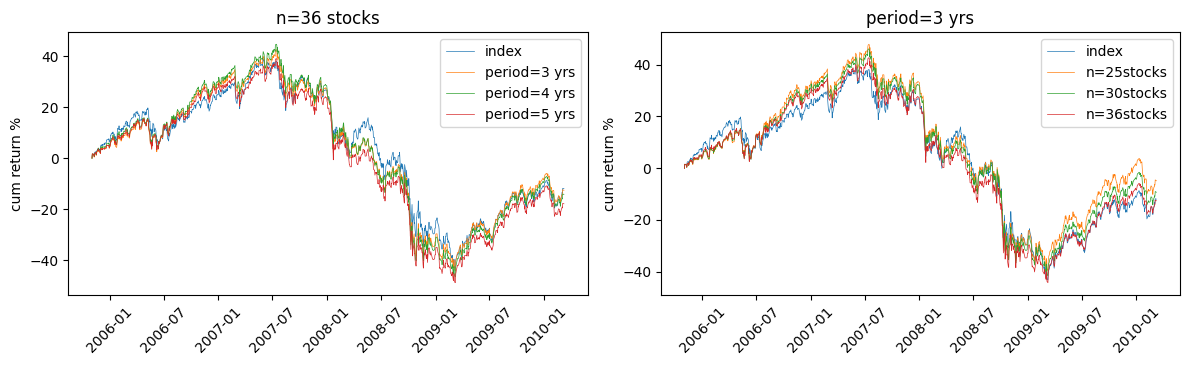

In [78]:
n = 36
cal_period = 3
plot_cumulatives(n, cal_period, trackers_dict, tracked_index, start_date)

In [4]:
select_strat = 'RA'
freq_rank = 3
n_list = np.array([25, 30, 36])
cal_period_list = np.array([3, 4, 5])
day_shift = 10
end_date = stocks.index[-1]
trackers_dict_F = {}
for n in n_list:
    for cal_period in cal_period_list:
        tracker_ret, tracker_TC_unit, coint_t = tracking_portf(n, freq_rank, select_strat, cal_period, start_date, end_date, 
                                                                  tracked_index, day_shift, stocks, poids)
        trackers_dict_F[(n, cal_period)] = [tracker_ret, tracker_TC_unit, coint_t]

In [80]:
df_res_tracking_F = results_tracking(trackers_dict_F, tracked_index, start_date)
df_res_tracking_F

,n,cal_period,adf,ret_an(%),vol_an(%),ret_sharpe,ret_corr,ret_skew,ret_kurt,ret_tc_an(%),vol_tc_an(%),ret_tc_shar,ret_tc_corr,ret_tc_skew,ret_tc_kurt
0,25,3,-7.692975,-0.738987,26.201174,-0.028204,0.954182,0.257769,9.527657,-1.147964,26.200725,-0.043814,0.954174,0.257577,9.528229
1,25,4,-7.170045,-1.393725,26.411852,-0.052769,0.952625,0.267232,9.046457,-1.802920,26.410732,-0.068265,0.952620,0.267252,9.046344
2,25,5,-6.648629,-1.333675,26.183932,-0.050935,0.952372,0.300553,8.529947,-1.722551,26.183712,-0.065787,0.952368,0.300146,8.530204
3,30,3,-7.418784,-1.837808,25.621508,-0.071729,0.957034,0.177244,9.254535,-2.274912,25.620534,-0.088793,0.957025,0.177329,9.254883
4,30,4,-7.133854,-2.057503,25.977700,-0.079203,0.956413,0.221108,8.999853,-2.495466,25.976363,-0.096067,0.956404,0.221098,8.999692
5,30,5,-7.184516,-1.514872,25.803256,-0.058709,0.953685,0.240754,8.473299,-1.950103,25.802334,-0.075579,0.953675,0.240876,8.473953
6,36,3,-8.599120,-2.992448,25.296870,-0.118293,0.958280,0.165365,9.514079,-3.398436,25.296459,-0.134344,0.958271,0.165187,9.514656
7,36,4,-8.075430,-3.402086,25.668060,-0.132542,0.957454,0.169693,9.726848,-3.824841,25.667127,-0.149017,0.957441,0.169459,9.728436
8,36,5,-7.601239,-4.381836,25.528659,-0.171644,0.956967,0.151953,9.125218,-4.801501,25.527707,-0.188090,0.956956,0.152027,9.126616


In [81]:
df_res_exc_ret_F = results_exc_ret(trackers_dict_F, tracked_index, start_date)
df_res_exc_ret_F

,n,cal_period,adf,exc_ret_an(%),exc_vol_an(%),exc_ret_sharpe,exc_ret_corr,exc_ret_skew,exc_ret_kurt,exc_ret_tc_an(%),exc_vol_tc_an(%),exc_ret_tc_shar,exc_ret_tc_corr,exc_ret_tc_skew,exc_ret_tc_kurt
0,25,3,-7.692975,2.091345,7.868684,0.265781,-0.085162,1.095946,24.957416,1.682368,7.869241,0.213790,-0.085236,1.096918,24.953834
1,25,4,-7.170045,1.436607,8.049304,0.178476,-0.063387,1.161194,23.528063,1.027413,8.049445,0.127638,-0.063534,1.162247,23.531886
2,25,5,-6.648629,1.496657,8.018135,0.186659,-0.091537,0.934079,21.234289,1.107781,8.018434,0.138154,-0.091573,0.934572,21.234546
3,30,3,-7.418784,0.992524,7.518092,0.132018,-0.152983,0.966694,27.344601,0.555420,7.518756,0.073871,-0.153125,0.967074,27.334222
4,30,4,-7.133854,0.772829,7.630717,0.101279,-0.108167,0.968301,25.780754,0.334867,7.631277,0.043881,-0.108358,0.969236,25.781092
5,30,5,-7.184516,1.315460,7.834244,0.167912,-0.135640,1.082666,24.295464,0.880229,7.834914,0.112347,-0.135773,1.083502,24.287245
6,36,3,-8.599120,-0.162116,7.370537,-0.021995,-0.193923,1.064122,29.782247,-0.568104,7.371335,-0.077069,-0.193988,1.064666,29.775131
7,36,4,-8.075430,-0.571754,7.487903,-0.076357,-0.146211,1.032755,27.982453,-0.994509,7.488907,-0.132798,-0.146355,1.032936,27.983200
8,36,5,-7.601239,-1.551504,7.511541,-0.206549,-0.165176,1.018672,27.494165,-1.971169,7.512327,-0.262391,-0.165315,1.018483,27.488121


In [19]:
df_res_tracking_F.to_excel('trackers_F2_RSA.xlsx')
df_res_exc_ret_F.to_excel('track_error_F2_RSA.xlsx')

In [10]:
def plot_cumulatives_TC(cal_period, trackers_dict, trackers_dict_F):
    trackers = {k: v for k, v in trackers_dict.items() if k[1] == cal_period}
    trackers_F = {k: v for k, v in trackers_dict_F.items() if k[1] == cal_period}
    fig, axs = plt.subplots(1, 2, figsize=(12, 3.75))
    axs[0].set_title(f'period={cal_period} yrs, RD')
    axs[1].set_title(f'period={cal_period} yrs, F2')
    
    for id in trackers:
        TC = 100*trackers[id][1]
        axs[0].plot(TC.cumsum(), linewidth=0.5, label=f'period={id[0]} yrs')    
        axs[0].set_ylabel('cum TC %')
    for id in trackers_F:
        TC = 100*trackers_F[id][1]
        axs[1].plot(TC.cumsum(), linewidth=0.5, label=f'n={id[0]}stocks') 
        axs[1].set_ylabel('cum TC %') 
    for i in range(2):
        for label in axs[i].get_xticklabels():
            label.set_rotation(45)  
    axs[0].legend() 
    axs[1].legend()
    plt.tight_layout()
    
def plot_cumulatives_ex(cal_period, trackers_dict, trackers_dict_F, ret_ind):
    trackers = {k: v for k, v in trackers_dict.items() if k[1] == cal_period}
    trackers_F = {k: v for k, v in trackers_dict_F.items() if k[1] == cal_period}
    fig, axs = plt.subplots(1, 2, figsize=(12, 3.75))
    axs[0].set_title(f'period={cal_period} yrs, RD')
    axs[1].set_title(f'period={cal_period} yrs, F2')
    
    for id in trackers:
        exc_ret = 100*excess_ret(trackers[id][0], ret_ind)
        axs[0].plot(exc_ret.cumsum(), linewidth=0.5, label=f'period={id[0]} yrs')    
        axs[0].set_ylabel('cum exc return %')
    for id in trackers_F:
        exc_ret = 100*excess_ret(trackers[id][0], ret_ind)
        axs[1].plot(exc_ret.cumsum(), linewidth=0.5, label=f'n={id[0]}stocks') 
        axs[1].set_ylabel('cum exc return %') 
    for i in range(2):
        for label in axs[i].get_xticklabels():
            label.set_rotation(45)  
    axs[0].legend() 
    axs[1].legend()
    plt.tight_layout()

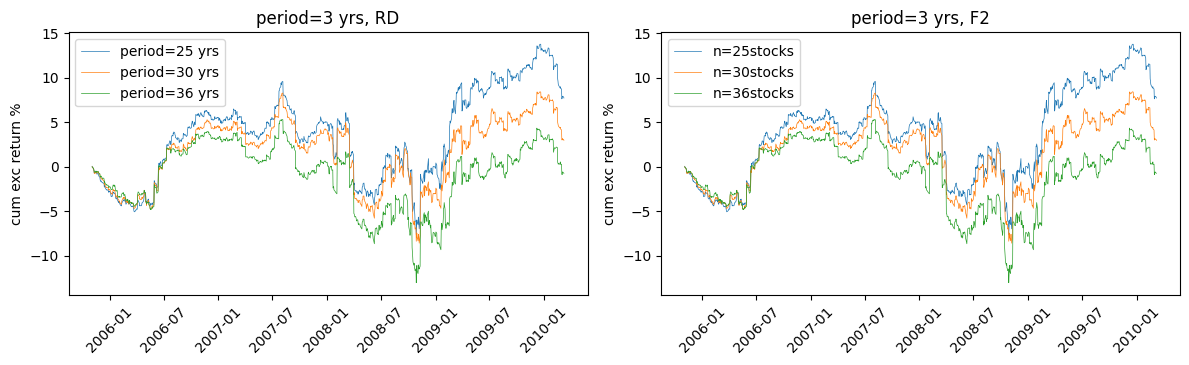

In [83]:
ret_ind = compute_ret(indice.loc[start_date:])
plot_cumulatives_ex(3, trackers_dict, trackers_dict_F, ret_ind)

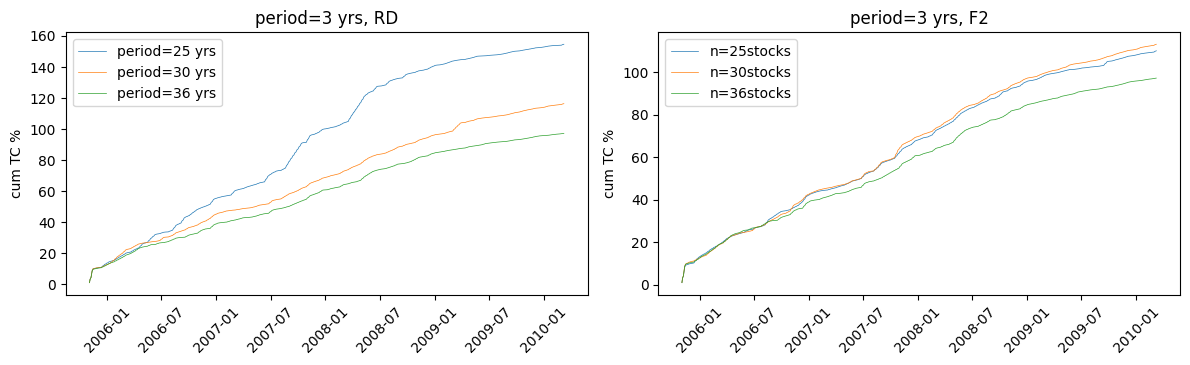

In [7]:
plot_cumulatives_TC(3, trackers_dict, trackers_dict_F)

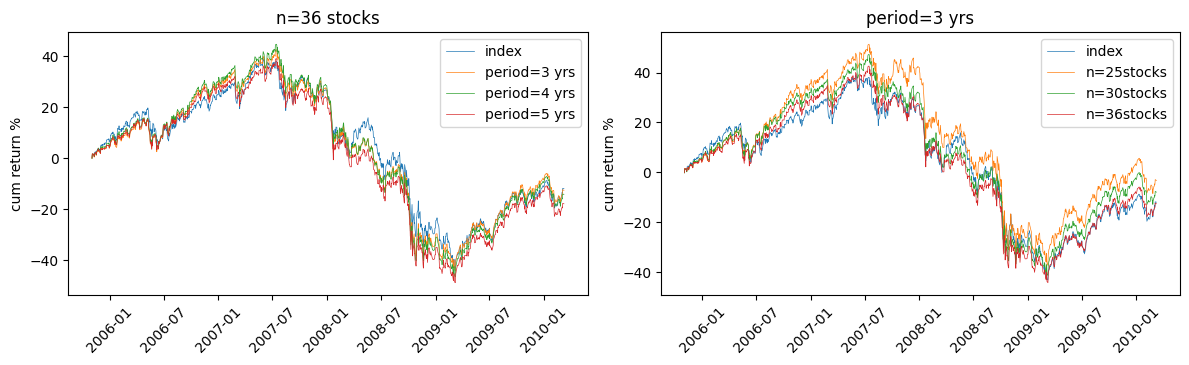

In [85]:
n = 36
cal_period = 3
plot_cumulatives(n, cal_period, trackers_dict_F, tracked_index, start_date)

##### Other plots

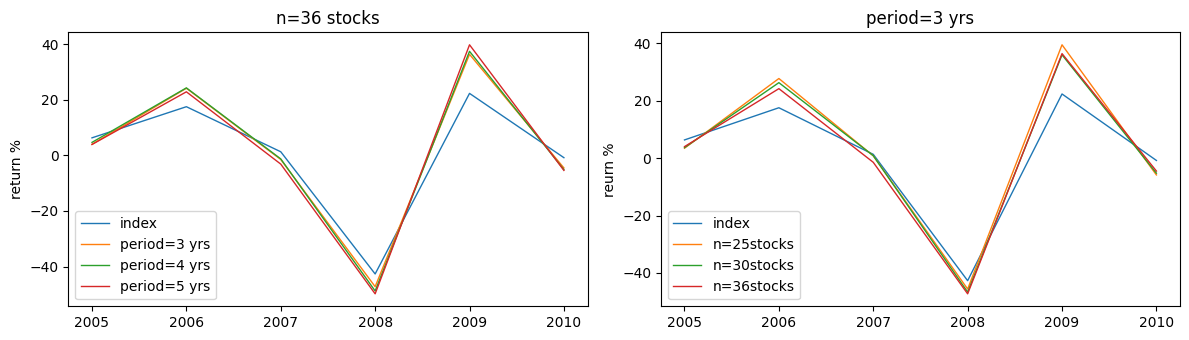

In [86]:
n = 36
cal_period = 3
plot_ret_an(n, cal_period, trackers_dict, tracked_index, start_date)

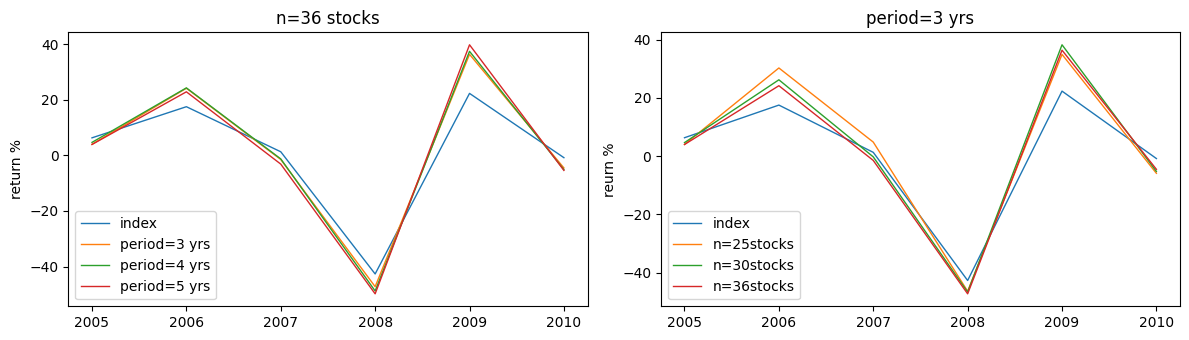

In [87]:
n = 36
cal_period = 3
plot_ret_an(n, cal_period, trackers_dict_F, tracked_index, start_date)

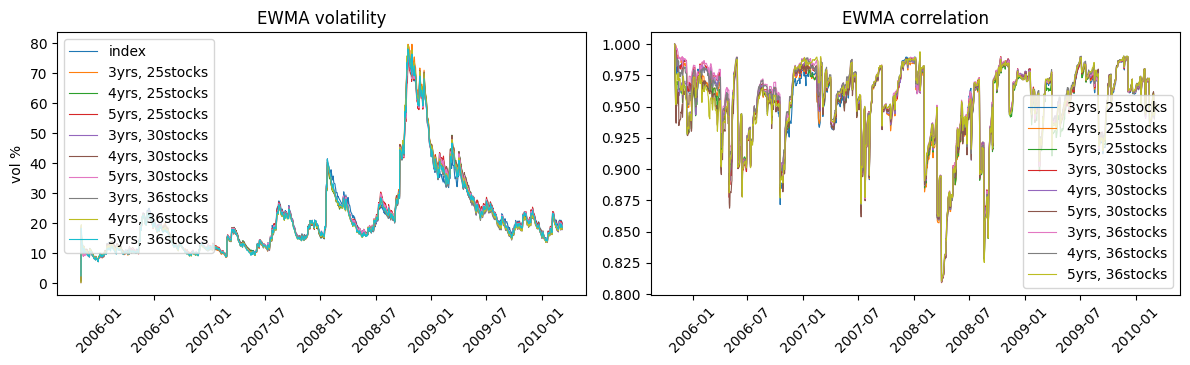

In [88]:
plot_ewma_vol_corr(trackers_dict, tracked_index, start_date, lambd=0.94)

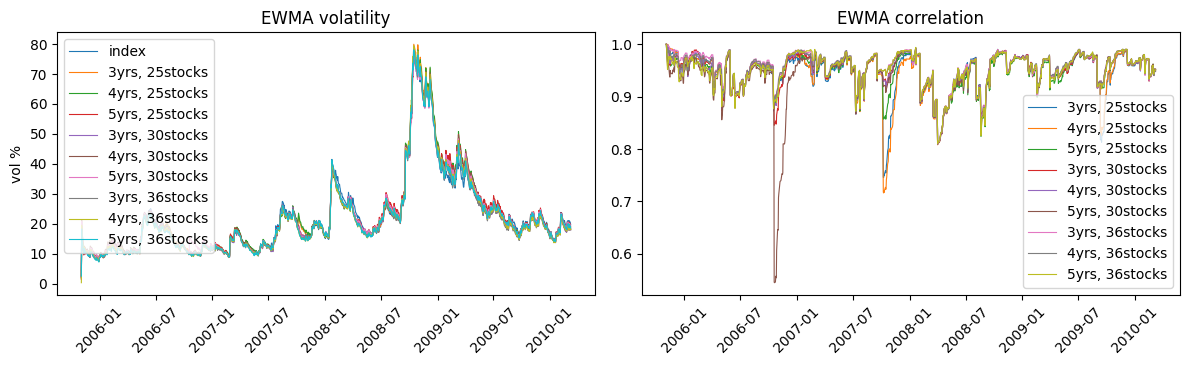

In [89]:
plot_ewma_vol_corr(trackers_dict_F, tracked_index, start_date, lambd=0.94)

## IV - Long-Short Market neutral strategies

In [23]:
x = 0.15
ind_plus = build_index_plus(indice, x)
ind_min = build_index_min(indice, x)

In [24]:
n_list = np.array([25, 30, 36])
end_date = pd.to_datetime("2009-01-02")
freq_rank = 1
cal_period = 3

coint_test_res_plus, dates, critical_values_plus = coint_test(cal_period, n_list, freq_rank, ind_plus, stocks, poids, day_shift, start_date, end_date)
coint_test_res_min, _, critical_values_min = coint_test(cal_period, n_list, freq_rank, ind_min, stocks, poids, day_shift, start_date, end_date)

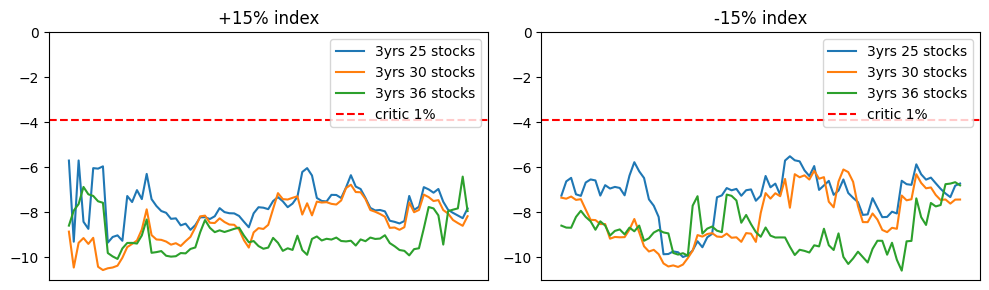

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
for i in range(len(coint_test_res_plus)):
    axs[0].plot(coint_test_res_plus[i], label=f'{cal_period}yrs {n_list[i]} stocks')
    axs[1].plot(coint_test_res_min[i], label=f'{cal_period}yrs {n_list[i]} stocks')
    
axs[0].set_title(f'+{int(100*x)}% index')
axs[0].axhline(y=critical_values_plus[0], color='r', linestyle='--', label="critic 1%")
axs[0].set_ylim(-11,0)
axs[0].xaxis.set_visible(False)
axs[0].legend()

axs[1].set_title(f'-{int(100*x)}% index')
axs[1].axhline(y=critical_values_min[0], color='r', linestyle='--', label="critic 1%")
axs[1].set_ylim(-11,0)
axs[1].xaxis.set_visible(False)
axs[1].legend()

fig.tight_layout()

In [64]:
def ls_features(ls_dict, tracked_index, start_date):
    ret_ind = compute_ret(tracked_index.loc[start_date:])
    res_ret = []
    for (plus, minus) in ls_dict.keys():
        ret = ls_dict[(plus, minus)][0]
        ret_tc = ls_dict[(plus, minus)][1]
        
        ret_an = 100*annualized_ret(ret)
        vol_an = 100*annualized_vol(ret)
        ret_corr = correlation(ret, ret_ind)
        ret_shar = ret_an / vol_an
        ret_skew = skew(ret, bias=False)
        ret_kurt = kurtosis(ret, bias=False)
        
        ret_tc_an = 100*annualized_ret(ret_tc)
        vol_tc_an = 100*annualized_vol(ret_tc)
        ret_tc_corr = correlation(ret_tc, ret_ind)
        ret_tc_shar = ret_tc_an / vol_tc_an
        ret_tc_skew = skew(ret_tc, bias=False)
        ret_tc_kurt = kurtosis(ret_tc, bias=False)
        
        res_ret.append({'+(%)':plus, '-(%)':minus, 'ret_an(%)':ret_an, 'vol_an(%)':vol_an, 'ret_sharpe':ret_shar, 
                             'ret_corr':ret_corr, 'ret_skew':ret_skew, 'ret_kurt':ret_kurt, 
                             'ret_tc_an(%)':ret_tc_an, 'vol_tc_an(%)':vol_tc_an, 'ret_tc_sharpe':ret_tc_shar, 
                             'ret_tc_corr':ret_tc_corr, 'ret_tc_skew':ret_tc_skew, 'ret_tc_kurt':ret_tc_kurt})
    df_res_ret = pd.DataFrame(res_ret)
    return df_res_ret

In [9]:
n_plus = 30
n_min = 36
freq_rank = 3 #2
select_strat = 'RA' #'RSA'
cal_period = 4   #3
day_shift = 10
end_date = stocks.index[-1]
tracked_index = indice

In [10]:
shift_list = np.array([0, 5, 10])
ls_dict = {}
for i, plus in enumerate(shift_list):
    for j, minus in enumerate(shift_list):
        print(plus, minus)
        ind_plus = build_index_plus(tracked_index, plus/100)
        ind_min = build_index_min(tracked_index, minus/100)
        ret_ls, ret_ls_tc = long_short_portf(n_plus, n_min, freq_rank, select_strat, cal_period, start_date, end_date, 
                                         ind_plus, ind_min, day_shift, stocks, poids)
        ls_dict[(plus, minus)] = [ret_ls, ret_ls_tc]
        

0 0
0 5
0 10
5 0
5 5
5 10
10 0
10 5
10 10


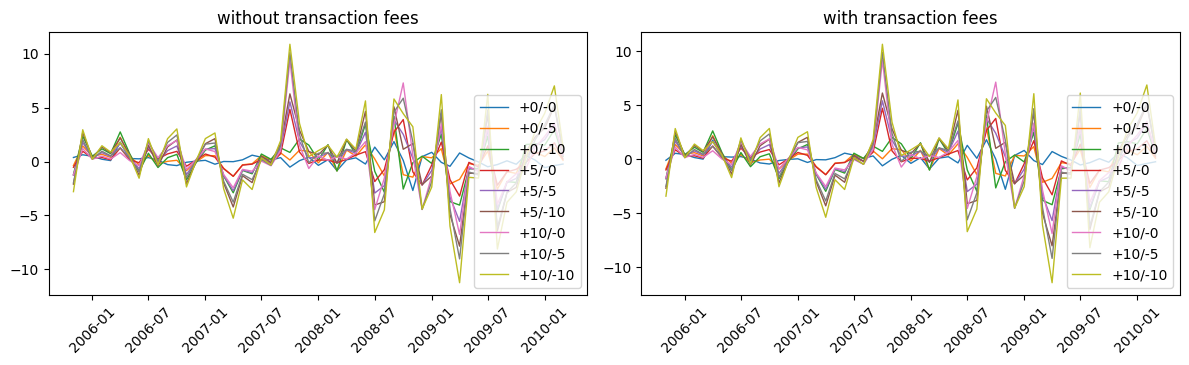

In [11]:
plot_ret_month_ls(ls_dict)

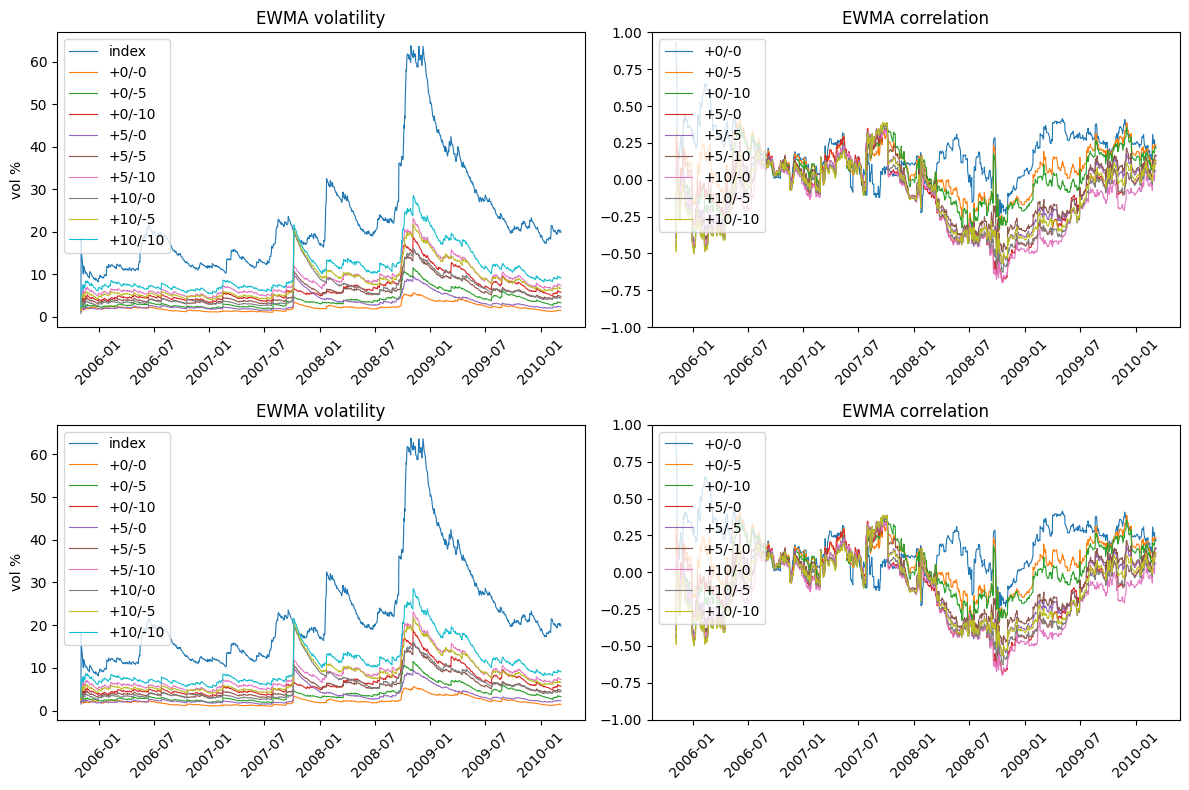

In [12]:
plot_ewma_vol_corr_ls(ls_dict, indice, start_date, lambd=0.97)

In [13]:
ls = ls_features(ls_dict, indice, start_date)

In [14]:
ls

,+(%),-(%),ret_an(%),vol_an(%),ret_sharpe,ret_corr,ret_skew,ret_kurt,ret_tc_an(%),vol_tc_an(%),ret_tc_sharpe,ret_tc_corr,ret_tc_skew,ret_tc_kurt
0,0,0,1.344582,2.394345,0.561566,0.112523,0.095632,10.422139,0.483864,2.396393,0.201914,0.111282,0.086085,10.429424
1,0,5,1.557840,4.342783,0.358719,-0.007025,-0.246501,15.266527,0.469175,4.345280,0.107973,-0.007718,-0.249815,15.261623
2,0,10,1.881819,7.350234,0.256022,-0.046642,-0.376227,12.060707,0.411326,7.352951,0.055940,-0.047069,-0.376355,12.038947
3,5,0,2.197069,3.772407,0.582405,-0.260430,2.939619,47.970130,1.236260,3.774640,0.327517,-0.260841,2.932128,47.899110
4,5,5,2.410327,6.306568,0.382193,-0.203340,0.390503,12.930012,1.221570,6.309455,0.193609,-0.203630,0.389721,12.922707
5,5,10,2.734306,9.372761,0.291729,-0.170142,-0.126169,8.900112,1.163721,9.376090,0.124116,-0.170364,-0.125056,8.888032
6,10,0,2.690511,7.125126,0.377609,-0.290348,3.851767,62.132217,1.402611,7.126613,0.196813,-0.290562,3.849812,62.119518
7,10,5,2.903769,9.320940,0.311532,-0.254126,1.637929,24.169813,1.387921,9.323452,0.148863,-0.254298,1.637540,24.162016
8,10,10,3.227747,12.080042,0.267197,-0.221938,0.617450,12.131929,1.330072,12.083299,0.110075,-0.222083,0.618471,12.125402


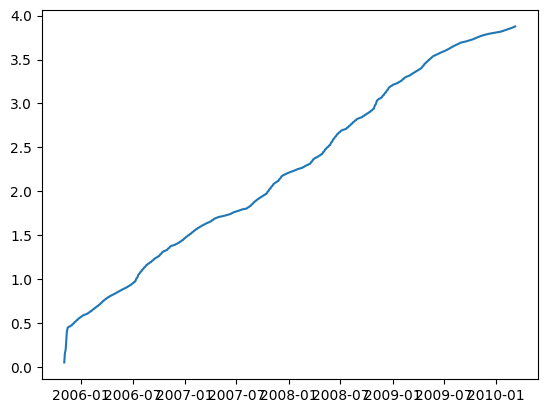

In [17]:
trans_cost = 100*(ls_dict[(0,0)][0] - ls_dict[(0,0)][1])
plt.plot(trans_cost.cumsum())